In [1]:
from datetime import timedelta
import os
import random
from math import ceil, pi

import keras
import plotly.io
import plotly.offline
import plotly.express as px
import polars as pl
import polars.selectors as cs
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

random.seed(3)
tf.random.set_seed(3)

plotly.offline.init_notebook_mode(connected=True)
plotly.io.templates.default = "plotly_dark"

2024-05-20 14:40:54.747828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.1


In [2]:
INPUT_DIR = os.path.abspath("input")  # directory with inputs from the competition

TARGET_STEPS = 16  # length of the target sequences
TRAIN_STEPS = 800  # limit on the number of timesteps in the training set

BATCH_SIZE = 64
BUFFER_SIZE = 1_000  # for Dataset shuffling

# the Kaggle competition uses Root Mean Squared Logarithmic Error
MSLE = keras.losses.MeanSquaredLogarithmicError()

# DATA PREPARATION

In [3]:
def _read_metadata(steps: int) -> pl.DataFrame:
    df = pl.read_csv(source=os.path.join(INPUT_DIR, "oil.csv"), try_parse_dates=True)
    df = df.set_sorted("date").upsample("date", every="1d")
    df = df.interpolate().fill_null(strategy="backward")

    # add a weekday signal (cos and sin)
    df = df.with_columns(weekday=(2 * pi * (pl.col("date").dt.weekday() - 1) / 7))
    df = df.with_columns(cos_wd=pl.col("weekday").cos(), sin_wd=pl.col("weekday").sin())
    df = df.drop("weekday")

    return df.tail(steps)

In [4]:
def _read_data(steps: int):
    train = pl.read_csv(
        source=os.path.join(INPUT_DIR, "train.csv"), try_parse_dates=True
    ).drop("id")

    target = (
        pl.read_csv(os.path.join(INPUT_DIR, "test.csv"), try_parse_dates=True)
        .with_columns(sales=pl.lit(None))
        .select(train.columns)
    )

    df = pl.concat([train, target])
    df = df.filter(pl.col("date") > pl.col("date").max() - timedelta(steps))

    # map each (store_nbr, family) pair to a key (integer)
    df = (
        df.select(["store_nbr", "family"])
        .group_by(["store_nbr", "family"], maintain_order=True)
        .agg()
        .with_row_index("key")
        .join(df, on=["store_nbr", "family"])
    )

    # build a map: key -> (store_nbr, family)
    km = {row["key"]: (row["store_nbr"], row["family"]) for row in df.to_dicts()}

    df = (
        df.pivot(index="date", values=["sales", "onpromotion"], columns="key")
        .set_sorted("date")
        .upsample("date", every="1d")
        .interpolate()
    )

    return df, km

In [110]:
class StandardScaler:
    def __init__(self, xs: tf.Tensor):
        # compute mean and standatd deviation along the time axis
        self.mean = tf.math.reduce_mean(xs, axis=1, keepdims=True)
        self.std = tf.math.reduce_std(xs, axis=1, keepdims=True)

        # replace low values of std with ones to avoid division by ~zero
        self.std = tf.where(self.std < 0.1, tf.ones_like(self.std), self.std)

    def scale(self, xs: tf.Tensor) -> tf.Tensor:
        return (xs - self.mean) / self.std

    def unscale(self, xs: tf.Tensor, keys: list[int] | None = None) -> tf.Tensor:
        keys = keys if keys is not None else list(range(self.mean.shape[0]))

        mean = tf.gather(self.mean, indices=keys, axis=0)[:, :, :1]
        std = tf.gather(self.std, indices=keys, axis=0)[:, :, :1]

        return (xs * std) + mean

In [111]:
class KeysDataFrame:
    def __init__(self, steps: int, include_target: bool):
        steps += TARGET_STEPS
        steps = steps + TARGET_STEPS if not include_target else steps

        meta_df = _read_metadata(steps).drop("date")
        data_df, self.keymap = _read_data(steps)

        if not include_target:
            meta_df = meta_df.head(-TARGET_STEPS)
            data_df = data_df.head(-TARGET_STEPS)

        # gather the data into a tensor -> dims = (time, key, feature)
        # features = [sales, onpromotion, dcoilwtico, cos_wd, sin_wd]
        data = tf.concat(
            [
                tf.expand_dims(data_df.select(cs.contains("sales")), -1),
                tf.expand_dims(data_df.select(cs.contains("onpromotion")), -1),
                tf.repeat(tf.expand_dims(meta_df, 1), len(self.keymap), axis=1),
            ],
            axis=-1,
        )

        data = tf.transpose(data, perm=[1, 0, 2])  # -> dims = (key, time, feature)
        data = tf.cast(data, dtype=tf.float32)

        self.inputs, self.target = tf.split(data, [-1, TARGET_STEPS], axis=1)

        # fit scaler to the input data and scale inputs and target
        self.scaler = StandardScaler(self.inputs)
        self.inputs = self.scaler.scale(self.inputs)
        self.target = self.scaler.scale(self.target)

    def select(self, target: bool = False, keys: list[int] | None = None) -> tf.Tensor:
        keys = keys if keys is not None else list(self.keymap.keys())
        data = self.target if target else self.inputs

        return tf.gather(data, indices=keys, axis=0)

## Dataset creation

In [54]:
# TODO give names to the values?

In [55]:
@tf.function  # TODO add input_signature?
def split_batch_window(
    window_batch: tf.Tensor,
) -> tuple[tuple[tf.Tensor, tf.Tensor, tf.Tensor], tf.Tensor]:
    """Splits a batch of windows into a batch of (inputs, labels) pairs."""

    # split along the time axis: window -> (inputs, labels)
    inp_vars, lab_vars = tf.split(window_batch, [-1, TARGET_STEPS], axis=1)

    # split features
    inp_sale, inp_meta = tf.split(inp_vars, [1, -1], axis=-1)
    lab_sale, lab_meta = tf.split(lab_vars, [1, -1], axis=-1)

    return (inp_sale, inp_meta, lab_meta), lab_sale

In [70]:
class KeysDataset:
    def __init__(
        self,
        kdf: KeysDataFrame,
        input_steps: int,
        keys: list[int] | None = None,
        train_ratio: float = 0.8,
    ):
        self.keys = keys if keys is not None else list(kdf.keymap.keys())
        self.window_steps = input_steps + TARGET_STEPS

        # split the total number of windows per key (train + valid)
        total_windows = kdf.inputs.shape[1] - 2 * self.window_steps + 2
        train_windows = int(total_windows * train_ratio)
        train_steps = train_windows + self.window_steps - 1

        data = kdf.select(target=False, keys=self.keys)
        data = tf.transpose(data, perm=[1, 0, 2])  # -> dims = (time, key, feature)
        train_data, valid_data = tf.split(data, [train_steps, -1], axis=0)

        self.train = self._make_dataset(train_data)
        self.valid = self._make_dataset(valid_data)

        self.train_batches = ceil(train_windows * len(self.keys) / BATCH_SIZE)

    def _make_dataset(self, data: tf.Tensor) -> tf.data.Dataset:
        ds = tf.data.Dataset.from_tensor_slices(data)  # spec = [keys, features]

        # window the time dimension -> spec = [window_steps, keys, features]
        ds = ds.window(size=self.window_steps, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda window: window.batch(self.window_steps))

        # -> spec = [keys, window_steps, features]
        ds = ds.map(lambda xs: tf.transpose(xs, perm=[1, 0, 2]))

        # split along the key dimension -> spec = [window_steps, features]
        ds = ds.flat_map(tf.data.Dataset.from_tensor_slices)

        return (
            ds.shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(split_batch_window, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
        )

---

In [77]:
def predict_target(
    model: keras.Model,
    kdf: KeysDataFrame,
    input_steps: int,
    keys: list[int] | None = None,
):
    # load inputs and target -> dims = (key, time, feature)
    inputs = kdf.select(target=False, keys=keys)
    target = kdf.select(target=True, keys=keys)

    _, inputs = tf.split(inputs, [-1, input_steps], axis=1)

    window = tf.concat([inputs, target], axis=1)  # concat along time axis

    (inp_sale, inp_meta, tar_meta), tar_sale = split_batch_window(window)

    return model([inp_sale, inp_meta, tar_meta])

--- 

In [112]:
kdf = KeysDataFrame(400, include_target=False)

In [71]:
kds = KeysDataset(kdf, 32)

In [72]:
var_count = kdf.inputs.shape[-1]

inp_sale = keras.Input(shape=[32, 1], name="InpSale")
inp_meta = keras.Input(shape=[32, var_count - 1], name="InpMeta")
tar_meta = keras.Input(shape=[TARGET_STEPS, var_count - 1], name="TarMeta")

timenet = keras.Sequential(
    [
        keras.Input(shape=[32, var_count]),
        # keras.layers.LSTM(16),
        keras.layers.Reshape([-1]),
        keras.layers.Dense(TARGET_STEPS),
        keras.layers.Reshape([TARGET_STEPS, 1]),
    ],
    name="TimeNet",
)

coupnet = keras.Sequential(
    [
        keras.Input(shape=[TARGET_STEPS, var_count]),
        # keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1),
    ],
    name="CoupNet",
)

inp_concat = keras.layers.Concatenate(axis=-1, name="InpConcat")
tar_concat = keras.layers.Concatenate(axis=-1, name="TarConcat")

inp_vars = inp_concat([inp_sale, inp_meta])
tar_Zvar = timenet(inp_vars)
tar_vars = tar_concat([tar_Zvar, tar_meta])
tar_pred = coupnet(tar_vars)

model = keras.Model(inputs=[inp_sale, inp_meta, tar_meta], outputs=tar_pred)

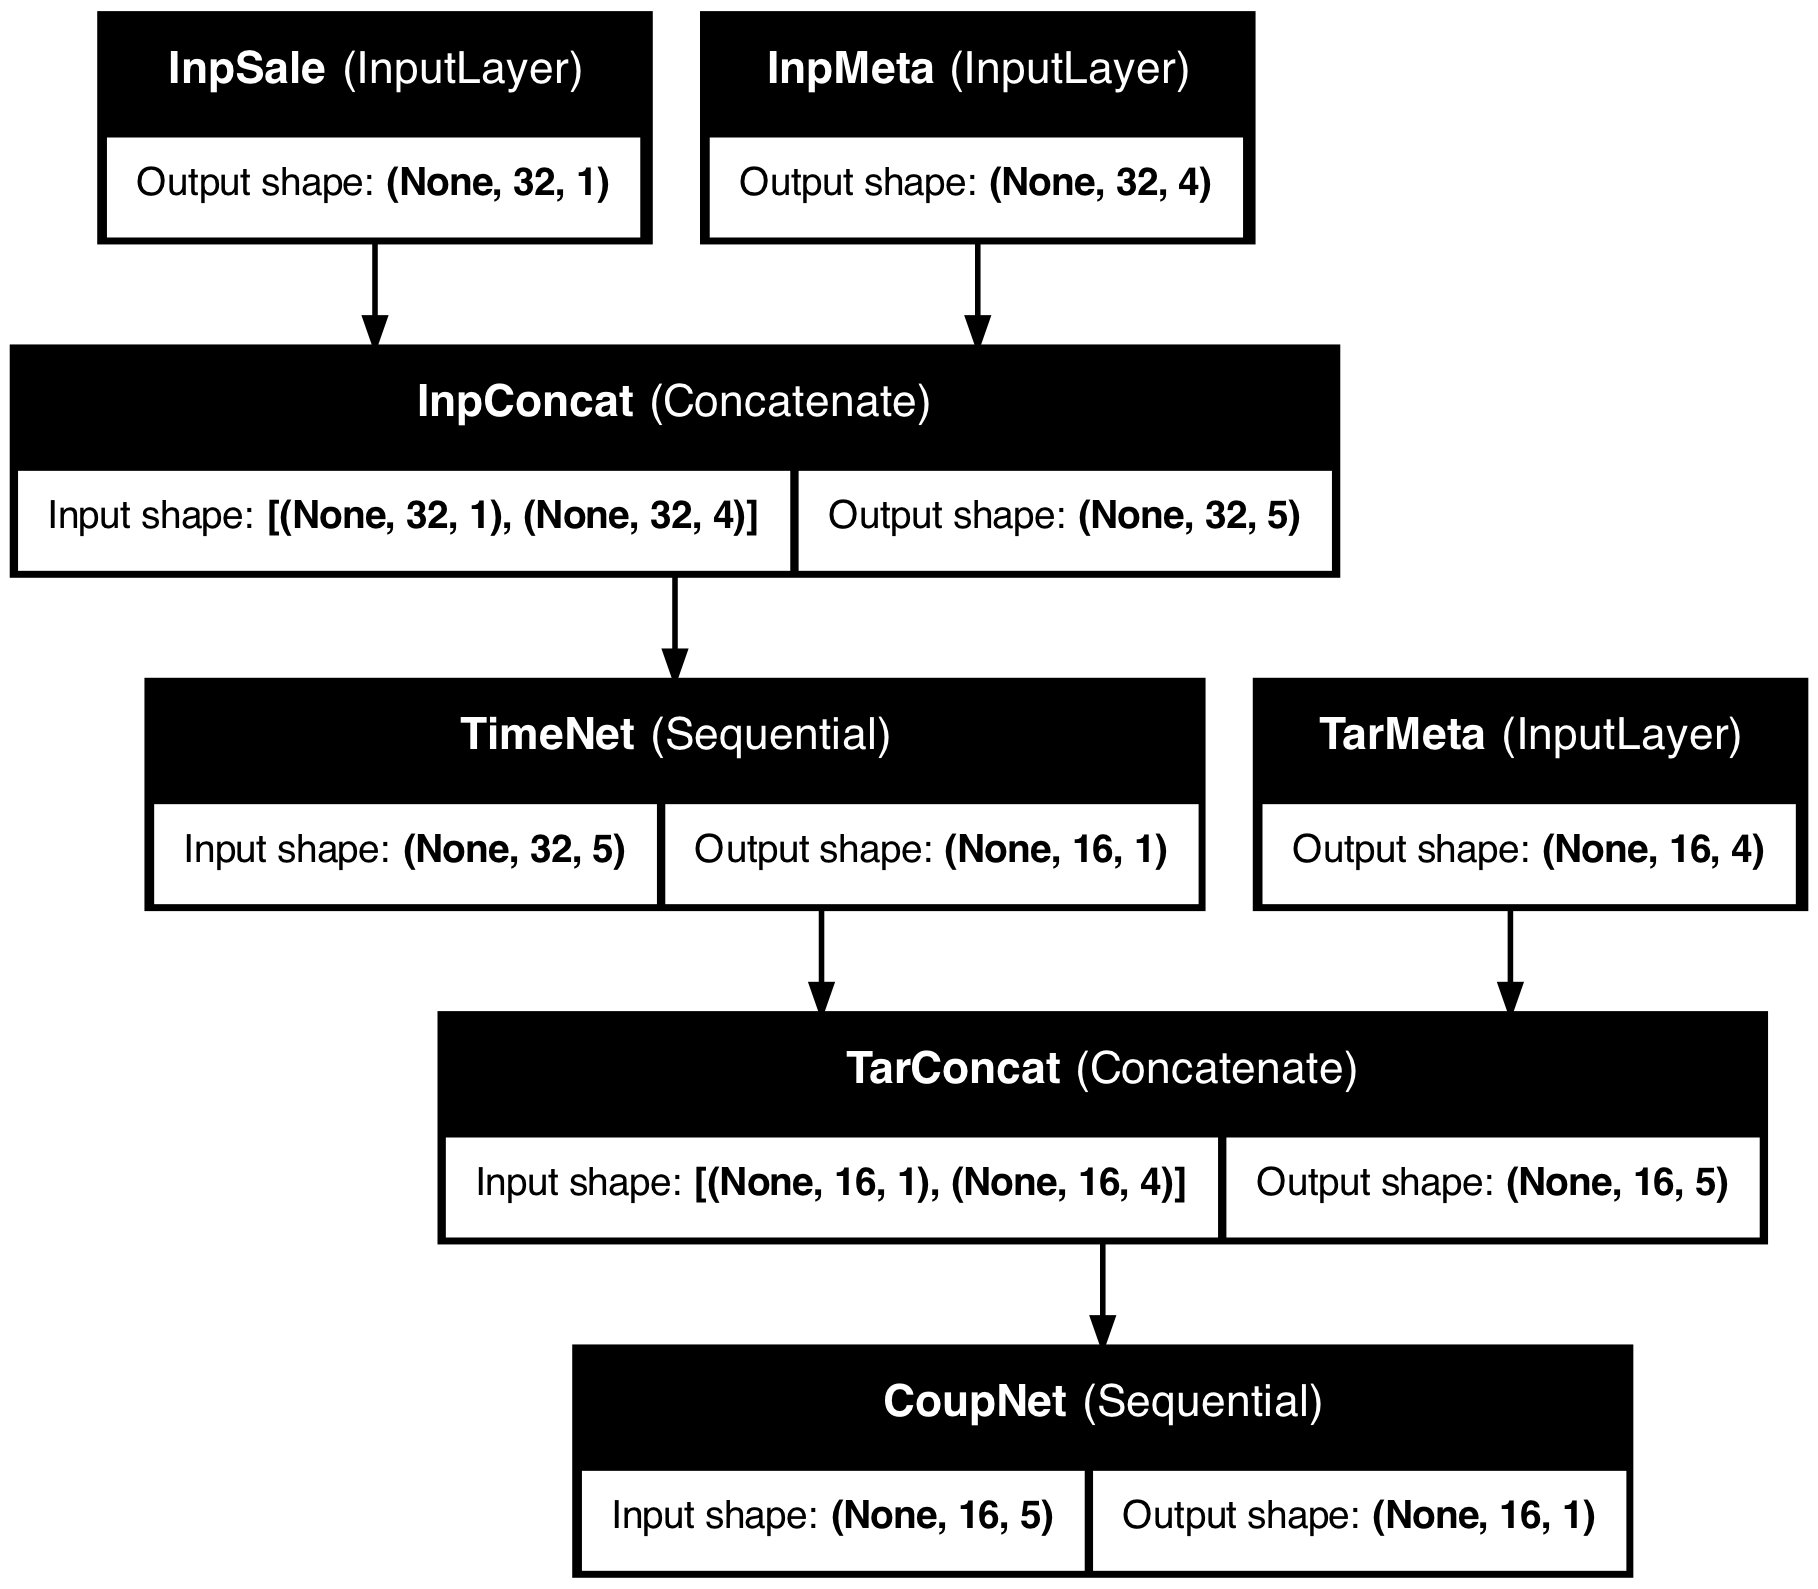

In [73]:
keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [74]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam())

In [ ]:
model.fit(kds.train, validation_data=kds.valid, epochs=10)

In [84]:
ys = kdf.select(target=True)[:, :, :1]

pred = predict_target(model, kdf, 32)

In [116]:
# the target is scaled in the KDF so need to unscale both
upred = kdf.scaler.unscale(pred)
uys = kdf.scaler.unscale(ys)

# NOTE Get MSLE = 0.23 with the very simple model
tf.reduce_mean(tf.keras.losses.MSLE(upred, uys))

<tf.Tensor: shape=(), dtype=float32, numpy=0.2398594>

In [123]:
# NOTE This is almost as good as what we had in _simple_models.ipynb
# NOTE but using a much smaller model, trained on less data.
# NOTE This is a good argument for using normalization.

# compute loss per key
pl.DataFrame(
    tf.reduce_mean(tf.keras.losses.MSLE(upred, uys), axis=1).numpy()
).describe()

statistic,column_0
str,f64
"""count""",1782.0
"""null_count""",0.0
"""mean""",0.239859
"""std""",0.494819
"""min""",0.000262
"""25%""",0.043314
"""50%""",0.125602
"""75%""",0.289944
"""max""",11.960413
